!pip install medmnist

# Medical Image Classification with MONAI

!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
%matplotlib inline

!pip install monai[all]

In [2]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121, resnet18
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.3.2
Numpy version: 1.26.4
Pytorch version: 2.4.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 59a7211070538586369afd4a01eca0a7fe2e742e
MONAI __file__: C:\Users\<username>\miniconda3\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.0+cpu
tqdm version: 4.65.0
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.15.1
pynrrd version: 1.0.0
clearml version: 1.16.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Continue working with OrganMNIST3d 64x64x64

In [3]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: C:\Users\ramka\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\ramka\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\ramka\.medmnist\organmnist3d_64.npz


In [4]:
root_dir = 'C:/Users/ramka/.medmnist/'

In [5]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: C:\Users\ramka\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [6]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [7]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        axial, coronal, sagittal = self.extract_2d_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}

        if self.transform:
            data['axial'] = self.transform(data['axial'])
            data['coronal'] = self.transform(data['coronal'])
            data['sagittal'] = self.transform(data['sagittal'])

        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [8]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def montage(dataset, length=20, replace=False, save_folder='C:/Users/ramka/OneDrive/Desktop/marina/dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice = 0
    elif flag == 'coronal':
        slice = 1
    else:
        slice = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

### Slices

In [10]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([111, 926, 171, 524, 545, 914, 632, 619, 616, 735])

In [11]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

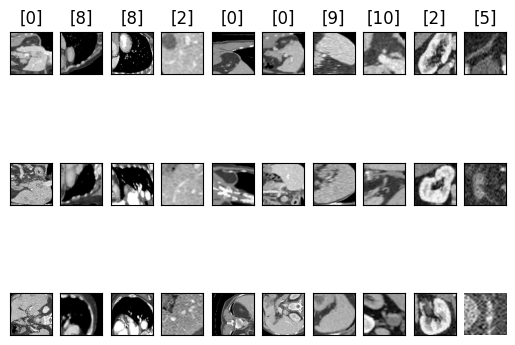

<Figure size 700x1500 with 0 Axes>

In [12]:
show_slice(train_dataset_, idx)

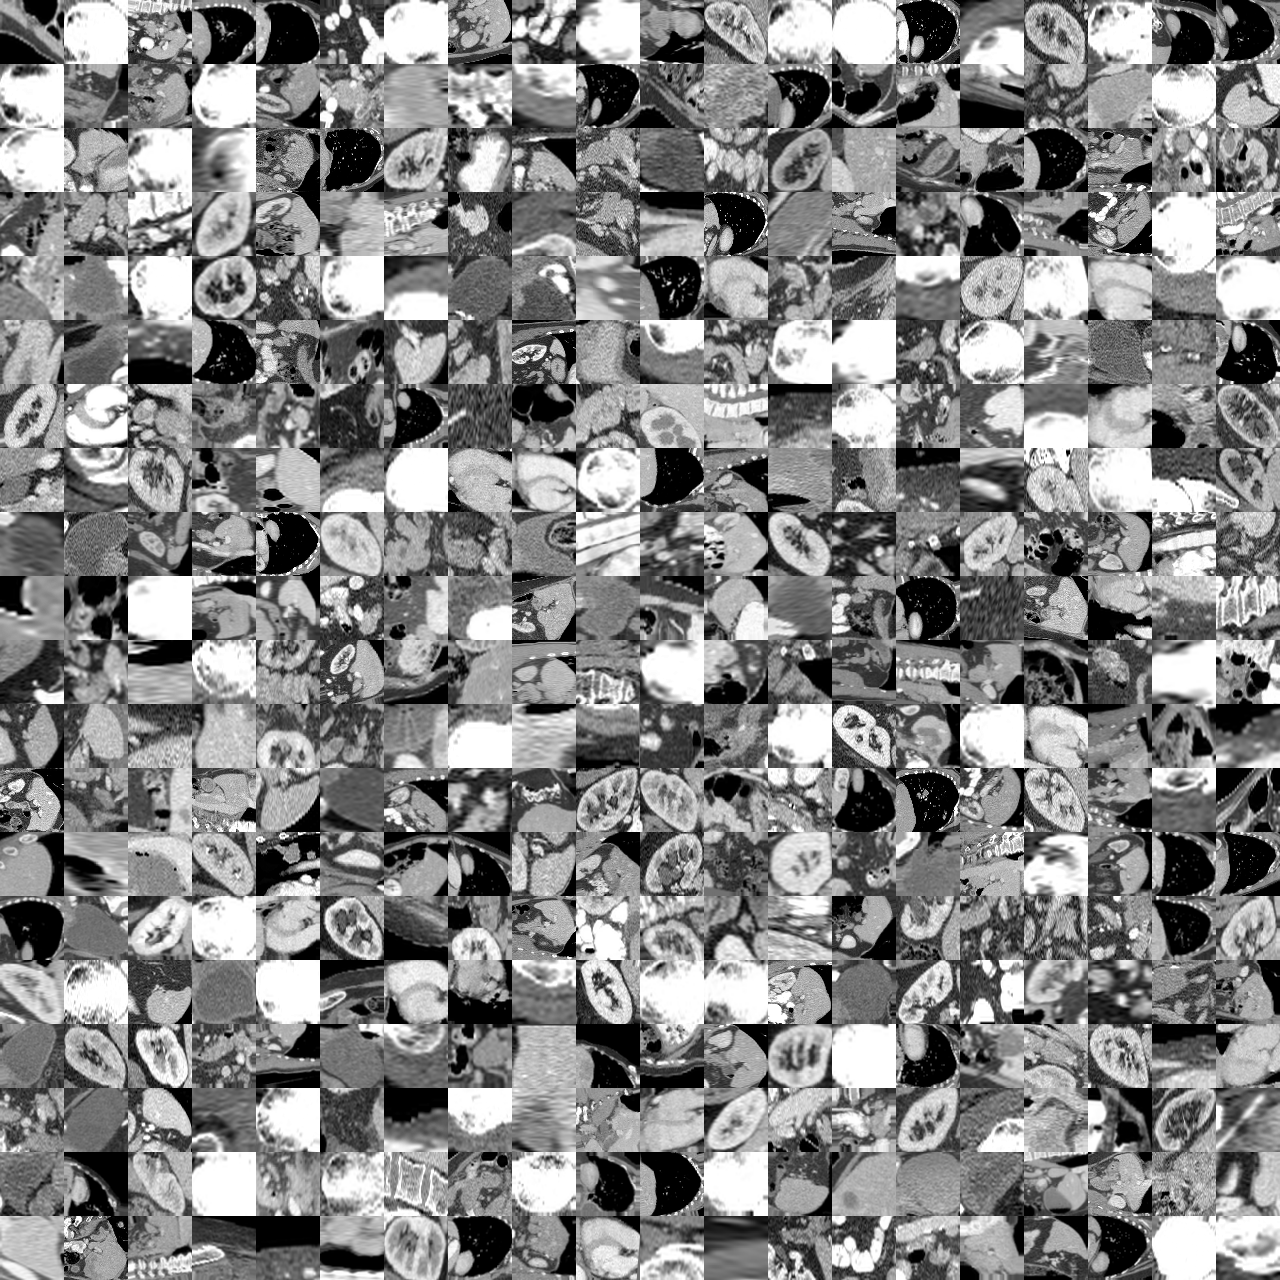

In [13]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

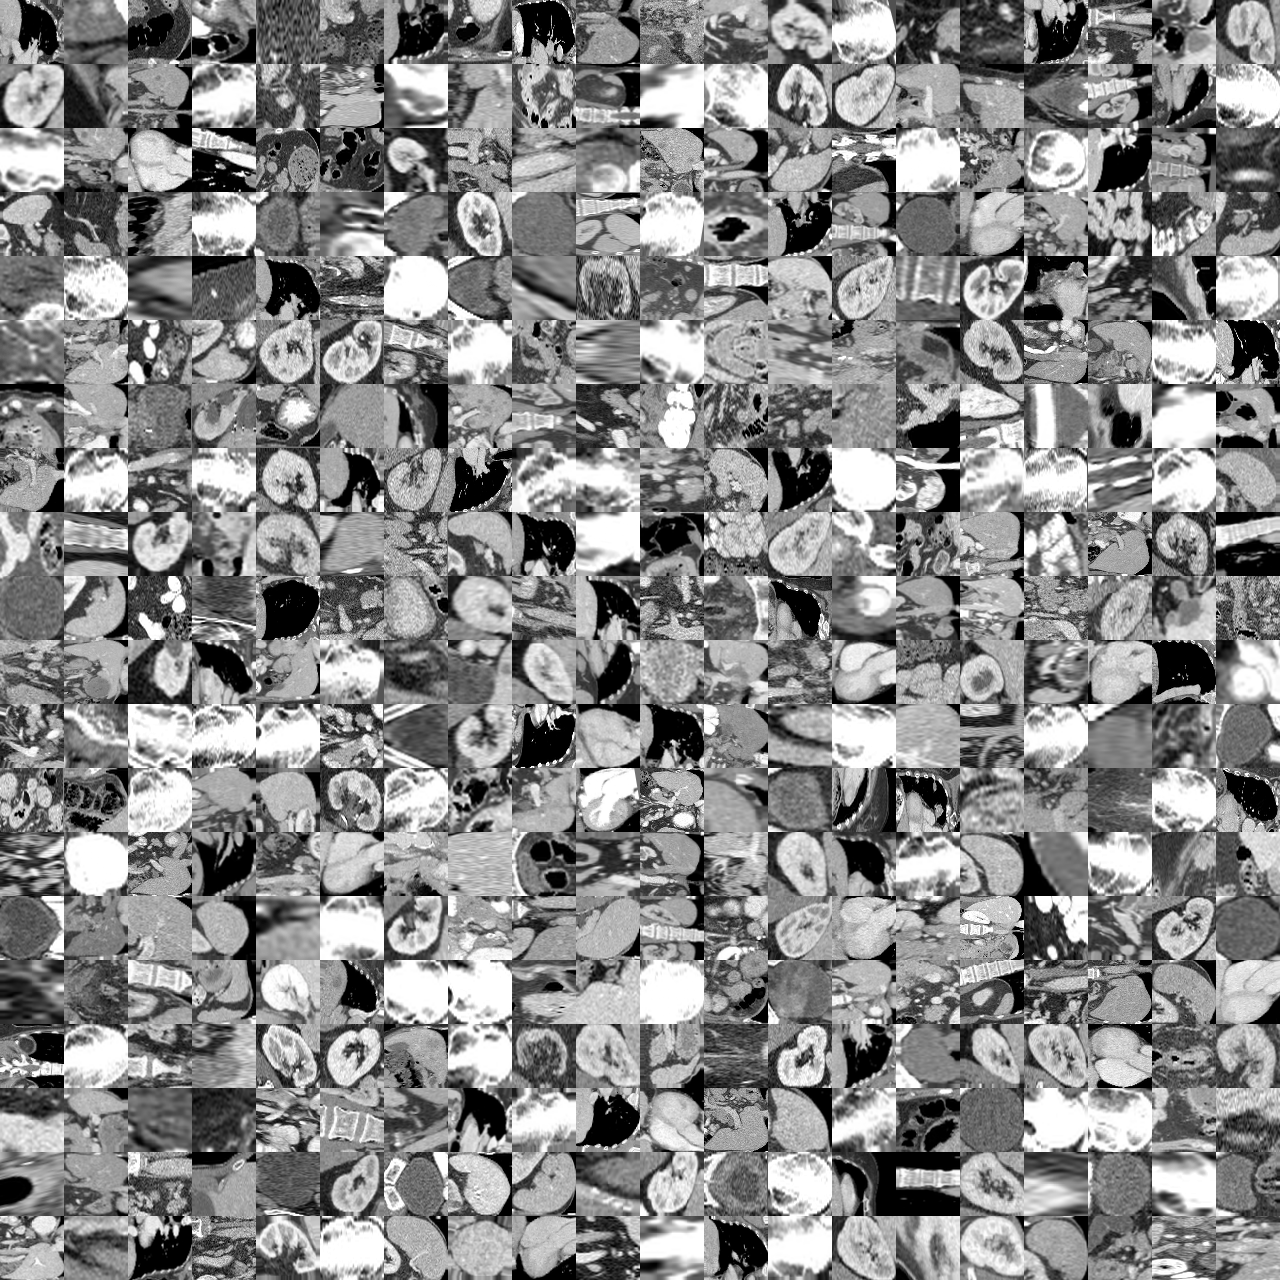

In [14]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

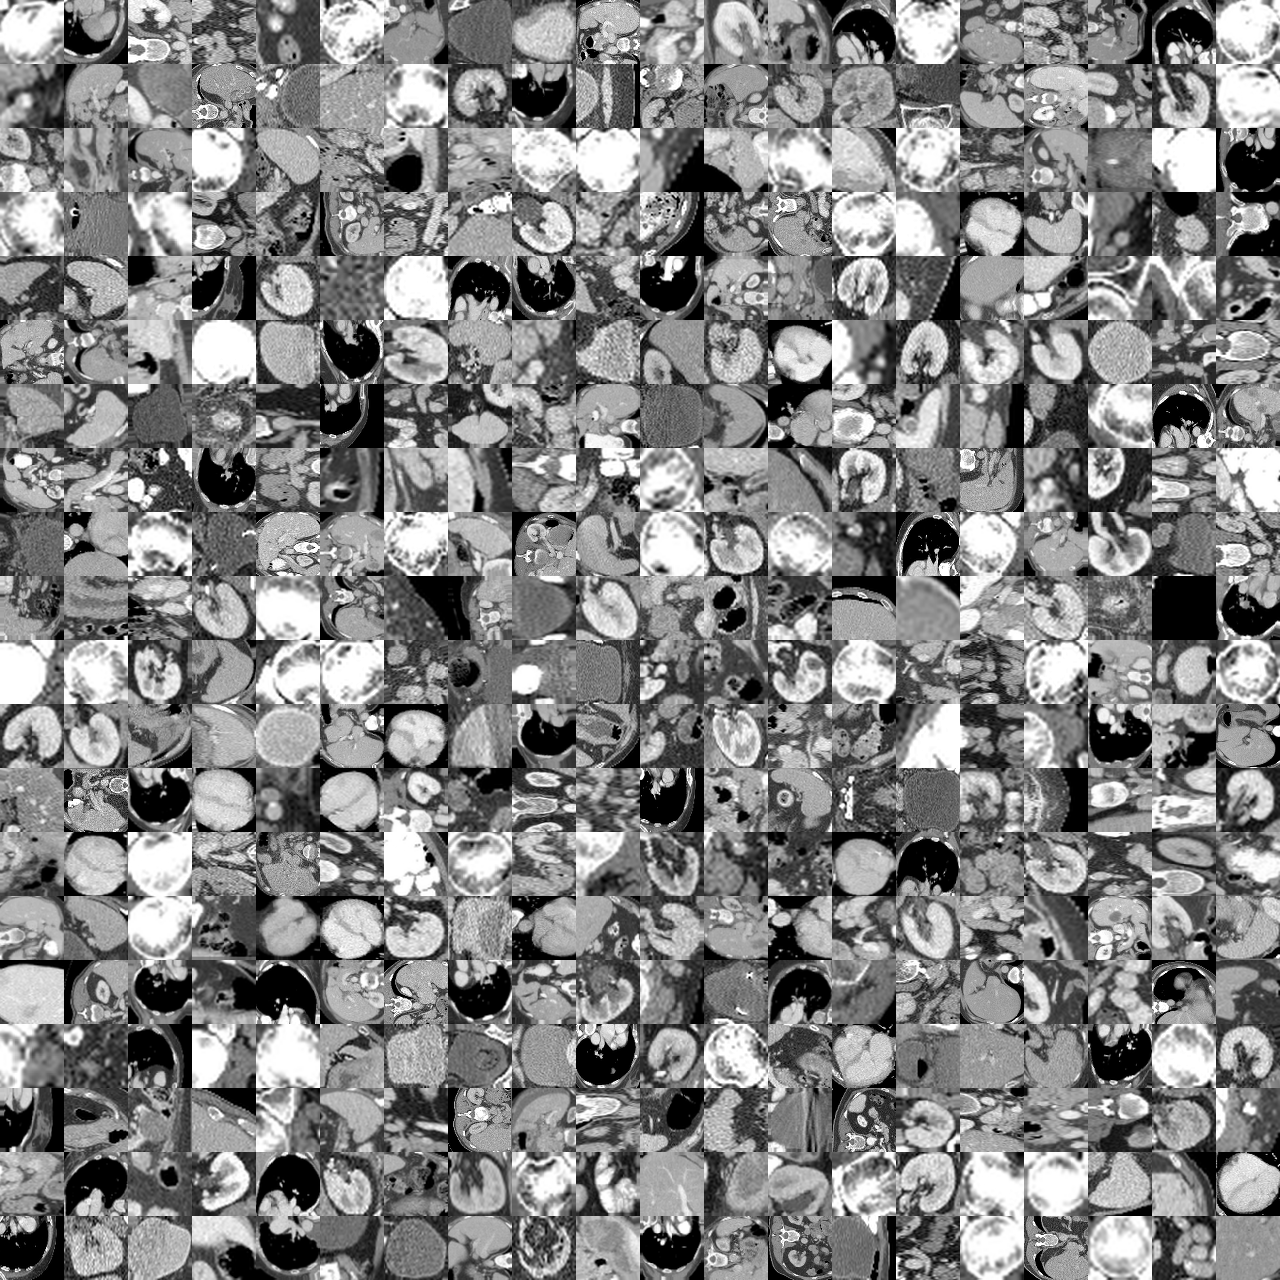

In [15]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

## Training cycle

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.6169
2/30, train_loss: 2.4811
3/30, train_loss: 2.3536
4/30, train_loss: 2.3239
5/30, train_loss: 2.3173
6/30, train_loss: 2.2511
7/30, train_loss: 2.2555
8/30, train_loss: 2.0572
9/30, train_loss: 2.0686
10/30, train_loss: 1.9329
11/30, train_loss: 2.2344
12/30, train_loss: 2.3412
13/30, train_loss: 2.1690
14/30, train_loss: 2.2344
15/30, train_loss: 2.1125
16/30, train_loss: 2.1602
17/30, train_loss: 2.0372
18/30, train_loss: 1.7041
19/30, train_loss: 2.0641
20/30, train_loss: 1.9251
21/30, train_loss: 1.7035
22/30, train_loss: 1.8497
23/30, train_loss: 2.0631
24/30, train_loss: 2.1403
25/30, train_loss: 1.8250
26/30, train_loss: 1.9100
27/30, train_loss: 1.7868
28/30, train_loss: 1.7783
29/30, train_loss: 1.8182
30/30, train_loss: 1.5344
31/30, train_loss: 1.5325
epoch 1 average loss: 2.0510
1
saved new best metric model
current epoch: 1 current AUC: 0.5784 current accuracy: 0.0932 best AUC: 0.5784 at epoch: 1
----------
epoch 2/100
1/30, t

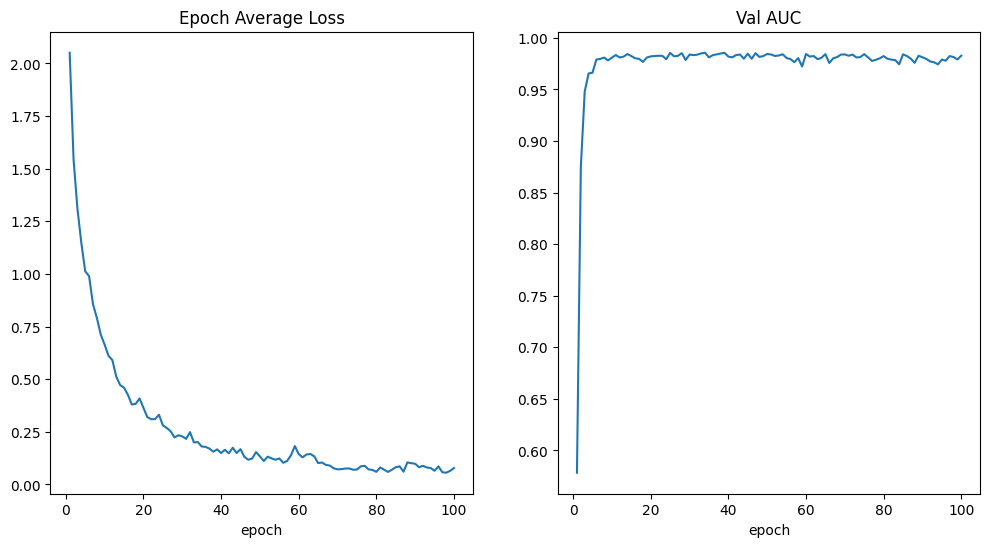

In [18]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [19]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [20]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8800    0.9565    0.9167        69
           1     0.5763    0.5000    0.5354        68
           2     0.5325    0.5942    0.5616        69
           3     0.5455    0.1846    0.2759        65
           4     0.4900    0.7538    0.5939        65
           5     0.8088    0.8333    0.8209        66
           6     0.8519    0.8214    0.8364        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.8364    0.6667    0.7419        69
          10     0.5833    0.7101    0.6405        69

    accuracy                         0.6836       610
   macro avg     0.7326    0.7292    0.7182       610
weighted avg     0.6888    0.6836    0.6712       610



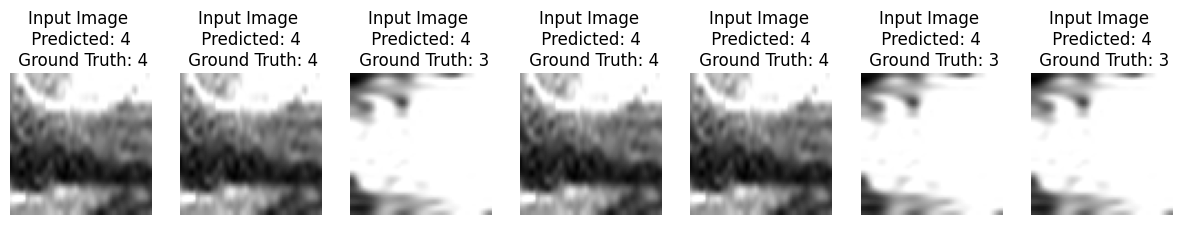

In [21]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, images.shape[0])
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(test_axial, pred, test_labels, n=7)

## Let's repeat the process for coronnal and sagittal parts of the dataset

### Training cycle for the coronal part

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [23]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.6049
2/30, train_loss: 2.4588
3/30, train_loss: 2.4645
4/30, train_loss: 2.3824
5/30, train_loss: 2.3919
6/30, train_loss: 2.4351
7/30, train_loss: 2.2808
8/30, train_loss: 2.2908
9/30, train_loss: 2.2286
10/30, train_loss: 2.2226
11/30, train_loss: 2.1099
12/30, train_loss: 2.2161
13/30, train_loss: 2.0788
14/30, train_loss: 2.2534
15/30, train_loss: 2.2685
16/30, train_loss: 2.0163
17/30, train_loss: 2.0778
18/30, train_loss: 2.0388
19/30, train_loss: 2.0360
20/30, train_loss: 2.0313
21/30, train_loss: 1.9801
22/30, train_loss: 1.8972
23/30, train_loss: 1.9653
24/30, train_loss: 1.7604
25/30, train_loss: 1.9275
26/30, train_loss: 1.8635
27/30, train_loss: 1.8725
28/30, train_loss: 1.9572
29/30, train_loss: 1.5790
30/30, train_loss: 1.8255
31/30, train_loss: 1.8351
epoch 1 average loss: 2.1081
1
saved new best metric model
current epoch: 1 current AUC: 0.5910 current accuracy: 0.0932 best AUC: 0.5910 at epoch: 1
----------
epoch 2/100
1/30, t

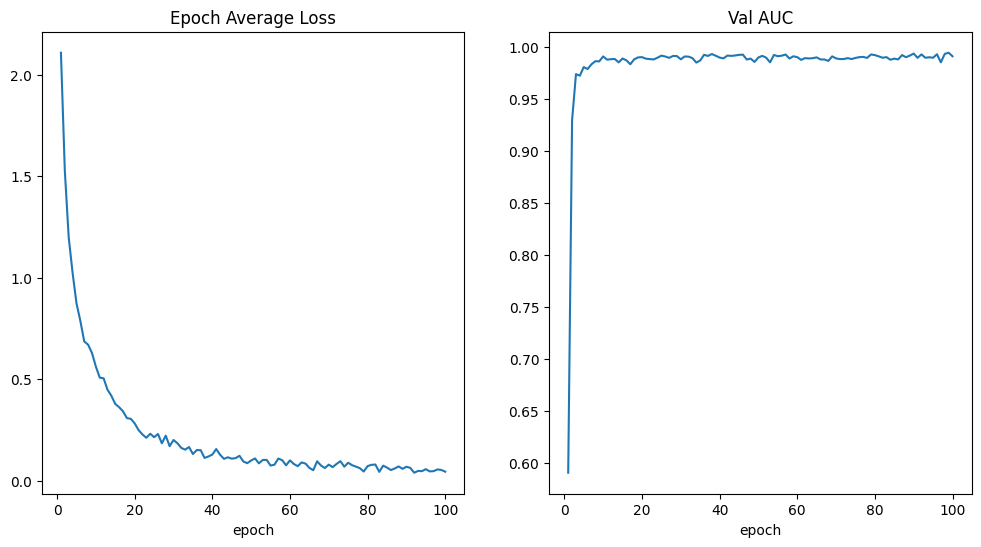

In [24]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [25]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [26]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8594    0.7971    0.8271        69
           1     0.5263    0.5882    0.5556        68
           2     0.5636    0.4493    0.5000        69
           3     0.4219    0.4154    0.4186        65
           4     0.4559    0.4769    0.4662        65
           5     0.7419    0.6970    0.7188        66
           6     0.6111    0.3929    0.4783        28
           7     0.8824    0.7143    0.7895        21
           8     0.8000    0.7619    0.7805        21
           9     0.5506    0.7101    0.6203        69
          10     0.3506    0.3913    0.3699        69

    accuracy                         0.5705       610
   macro avg     0.6149    0.5813    0.5931       610
weighted avg     0.5813    0.5705    0.5721       610



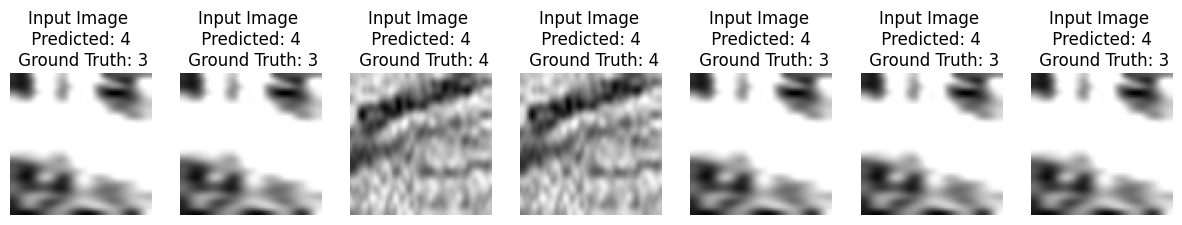

In [27]:
plot_examples(test_coronal, pred, test_labels, n=7)

### Training cycle for the sagittal part

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [29]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

----------
epoch 1/100
1/30, train_loss: 2.4695
2/30, train_loss: 2.4205
3/30, train_loss: 2.3311
4/30, train_loss: 2.3447
5/30, train_loss: 2.3053
6/30, train_loss: 2.2090
7/30, train_loss: 2.1939
8/30, train_loss: 2.1570
9/30, train_loss: 2.1711
10/30, train_loss: 2.0958
11/30, train_loss: 2.2601
12/30, train_loss: 2.1270
13/30, train_loss: 2.0572
14/30, train_loss: 2.1578
15/30, train_loss: 1.9497
16/30, train_loss: 1.9373
17/30, train_loss: 2.0998
18/30, train_loss: 1.8917
19/30, train_loss: 1.9638
20/30, train_loss: 1.8211
21/30, train_loss: 1.8447
22/30, train_loss: 1.9681
23/30, train_loss: 1.9249
24/30, train_loss: 2.0808
25/30, train_loss: 1.6676
26/30, train_loss: 1.7100
27/30, train_loss: 1.7781
28/30, train_loss: 1.7557
29/30, train_loss: 1.8845
30/30, train_loss: 1.8383
31/30, train_loss: 1.6212
epoch 1 average loss: 2.0335
1
saved new best metric model
current epoch: 1 current AUC: 0.5573 current accuracy: 0.0932 best AUC: 0.5573 at epoch: 1
----------
epoch 2/100
1/30, t

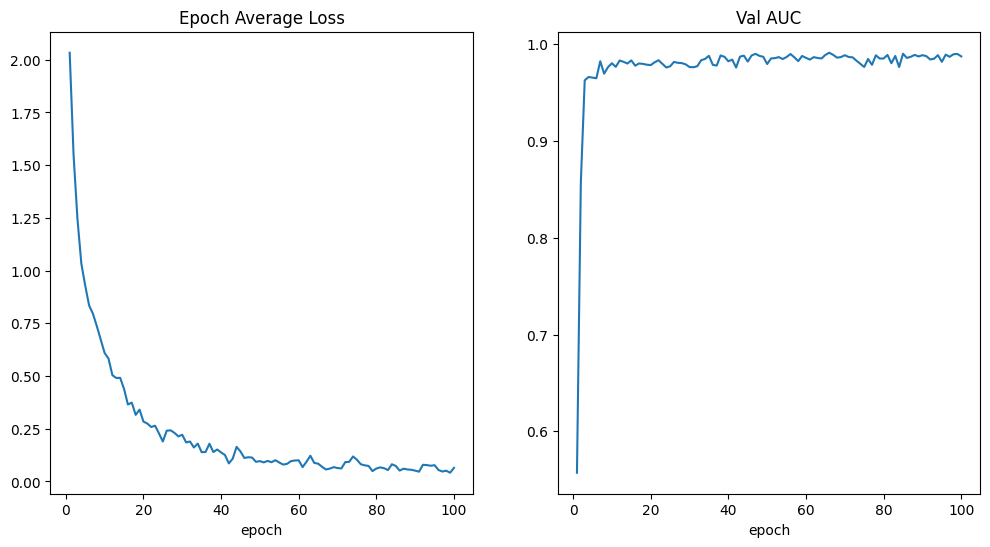

In [30]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluate the model on test dataset

In [31]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [32]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.5185    0.4058    0.4553        69
           1     0.3636    0.4118    0.3862        68
           2     0.2059    0.1014    0.1359        69
           3     0.6333    0.2923    0.4000        65
           4     0.4894    0.3538    0.4107        65
           5     0.4932    0.5455    0.5180        66
           6     0.6364    0.2500    0.3590        28
           7     0.3939    0.6190    0.4815        21
           8     0.0000    0.0000    0.0000        21
           9     0.3077    0.5797    0.4020        69
          10     0.2609    0.4348    0.3261        69

    accuracy                         0.3787       610
   macro avg     0.3912    0.3631    0.3522       610
weighted avg     0.4026    0.3787    0.3678       610



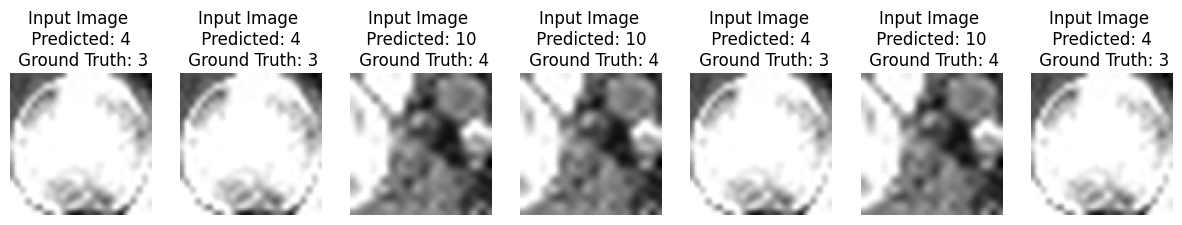

In [35]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## Use 2d models as a backbone

In [188]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [189]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

### Evaluate on a 3d dataset

In [190]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [191]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [192]:
for epoch in range(5):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.to(device).type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.6783915258223012
Epoch 2, Loss: 2.679837472977177
Epoch 3, Loss: 2.6806772139764603
Epoch 4, Loss: 2.686660220546107
Epoch 5, Loss: 2.6826048281884964


In [193]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images)
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.4587, Accuracy: 14.9441


## Hyper network

In [206]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [207]:
# Load the pretrained models for each slice direction
model_axial = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [208]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [209]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.to(device).type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.2544863723939463
Epoch 2, Loss: 1.7478429232874224
Epoch 3, Loss: 1.3688572683641989
Epoch 4, Loss: 1.0972467468630882
Epoch 5, Loss: 0.8561735883835824
Epoch 6, Loss: 0.7242158016850871
Epoch 7, Loss: 0.5892777471773086
Epoch 8, Loss: 0.49357645838491376
Epoch 9, Loss: 0.4354799062974991
Epoch 10, Loss: 0.37987005229919185
Epoch 11, Loss: 0.32183971328120076
Epoch 12, Loss: 0.2963679115618429
Epoch 13, Loss: 0.2693335952297334
Epoch 14, Loss: 0.24034898463756807
Epoch 15, Loss: 0.23136436746966454
Epoch 16, Loss: 0.21796819327339048
Epoch 17, Loss: 0.20469946678607695
Epoch 18, Loss: 0.18005606171584898
Epoch 19, Loss: 0.17062866110955516
Epoch 20, Loss: 0.1695724305125975
Epoch 21, Loss: 0.15770024037168873
Epoch 22, Loss: 0.14716058080234834
Epoch 23, Loss: 0.13281634786436636
Epoch 24, Loss: 0.1427022081709677
Epoch 25, Loss: 0.13350951671600342
Epoch 26, Loss: 0.12801217864597997
Epoch 27, Loss: 0.1159161701798439
Epoch 28, Loss: 0.11419806244873232
Epoch 29, Loss

In [210]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images)
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9962, Accuracy: 14.7391


In [211]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [212]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9855    0.9645        69
           1     0.6364    0.7206    0.6759        68
           2     0.7708    0.5362    0.6325        69
           3     0.5057    0.6769    0.5789        65
           4     0.5532    0.4000    0.4643        65
           5     0.9839    0.9242    0.9531        66
           6     1.0000    0.8929    0.9434        28
           7     0.9545    1.0000    0.9767        21
           8     1.0000    1.0000    1.0000        21
           9     0.8356    0.8841    0.8592        69
          10     0.8816    0.9710    0.9241        69

    accuracy                         0.7869       610
   macro avg     0.8242    0.8174    0.8157       610
weighted avg     0.7917    0.7869    0.7833       610

